**COMP0120 Project Code - Support Vector Machines (SVMs)**

**John Duffy, Student Number: 19154676**

# Global Imports, Variables and Actions

In [1]:
# Global imports.

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Global variables

TRAIN_N = [2]
CLASS_N = 1000

PLOTS = 6

In [3]:
# Seed random number generator for reproducibility.

np.random.seed(1)

# Dataset

For this project I have decided to use the Iris dataset included with Scikit-Learn. This is a well studied dataset in the literature, so may appear a *boring* choice. However, it provides clean and multi-class data which can be used to validate my code against other well established code, such as Scikit-Learn.

In [4]:
# Import and load Iris dataset.

from sklearn import datasets

iris = datasets.load_iris()

X = iris["data"]
y = iris["target"]
y_names = iris["target_names"]

# Introduction

## An Aside about Python and *lambda* expressions

In Python functions are first class citizens, which means just they can be passed to and returned from functions in the same manner as variables. This is simialr to MatLab function handles. And it is sometimes convenient, and clearer, to write a short function as a *lambda*, or an anonymous function, rather that a write a full function declaration. A *lambda* can be assigned to a variable, but it doesn't have to be.

For example:
```
def kernel_linear(xi, xj):
    return np.dot(xi, xj)
```
is the same as the following:
```
kernel_linear = lambda xi, xj: np.dot(xi, xj)
```
An example of using a *lambda* anonymously is as follows, which passes a kernel function as a parameter but without first assiging it to a variable:
```
classifier.train(X, y, lambda xi, xj: np.dot(xi, xj))
```
I have used this functionality throughout my code for clarity and brevity.

## Linear Binary Classification

Generate some images for my report.

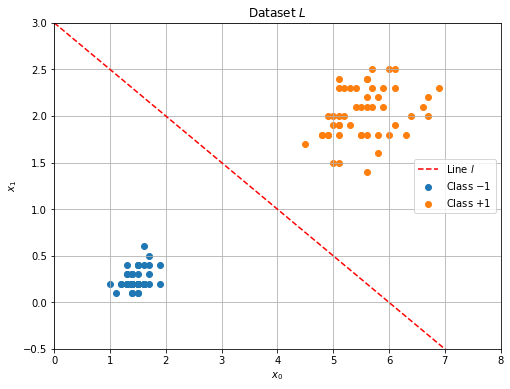

In [5]:
# intro_0.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_0.pdf")
plt.show()

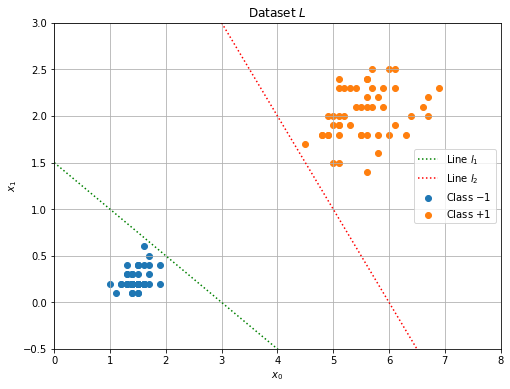

In [6]:
# intro_02.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.5
x1 = m * x0 + c
plt.plot(x0, x1, ":g", label="Line $l_1$")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1
c = 6
x1 = m * x0 + c
plt.plot(x0, x1, ":r", label="Line $l_2$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_1.pdf")
plt.show()

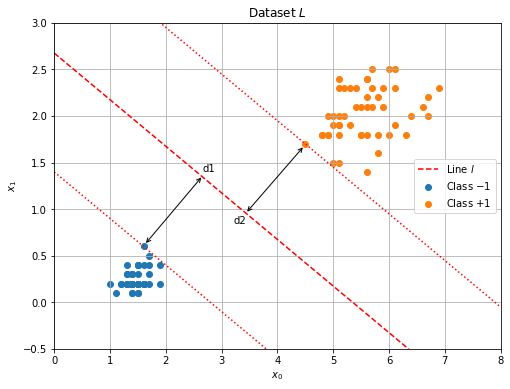

In [7]:
# intro_03.pdf

labels = ["Class $-1$", "Class $+1$"]

plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)

for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.4
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.95
x1 = m * x0 + c
plt.plot(x0, x1, ":r")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 2.675
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.annotate("d1", xy=(1.62, 0.62), xytext=(2.65, 1.4), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(4.48, 1.68), xytext=(3.21, 0.85), arrowprops=dict(arrowstyle="<->"))
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_2.pdf")
plt.show()

# Mathematical Setting

## Linear Binary Classification

### Backtracking and Steepest Descent

In [8]:
# Steepest_descent and backtracking.

def backtracking(f, df, x, p, alpha0=1.0, rho=0.1, c1=1e-4):
    '''
    This function implements the backtracking algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns a Numpy array of the alpha iterations.
    '''
    alpha = alpha0
    alphas = [alpha]
    while f(x + alpha * p) > f(x) + c1 * alpha * np.dot(df(x), p):
        alpha = rho * alpha
        alphas.append(alpha)
    return np.array(alphas)

def steepest_descent(f, df, d2, x0, tol=1e-6):
    '''
    This function implements the steepest descent algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns number of iterations and a Numpy array of the iterations steps.
    '''    
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, np.array(xs))


def newton(f, df, d2f, x0, tol=1e-6):
    '''
    This function implements the Newton descent algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns number of iterations and a Numpy array of the iterations steps.
    '''    
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * np.linalg.inv(d2f(x)) @ df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, np.array(xs))

### Rosenbrock Test (as per Assignment 1)

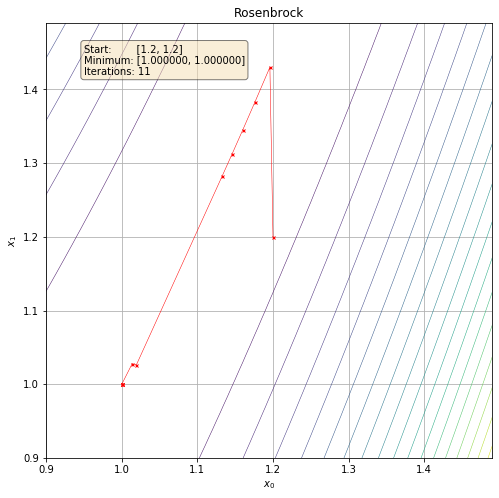

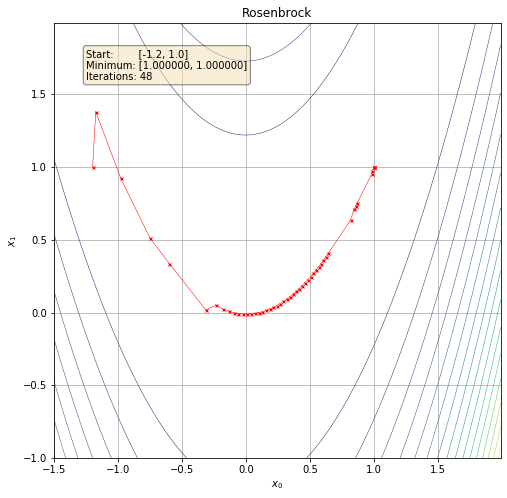

In [9]:
# Rosenbrock functionality test of backtracking and steepest descent.

a = 1
b = 100

f = lambda x: (a - x[0])**2 + b*(x[1] - x[0]**2)**2

df = lambda x: np.array([-2.0 * (a - x[0]) - 4.0 * b * x[0] * (x[1] - x[0]**2),
                         2.0 * b * (x[1] - x[0]**2)])

d2f = lambda x: np.array([[2 + 8 * b * x[0]**2 - 4.0 * b * (x[1] - x[0]**2), -4.0 * b * x[0]], [-4.0 * b * x[0], 2.0 * b]])


# rosenbrock_1.pdf

x0 = np.array([1.2, 1.2], dtype=np.float64)

#iters, xs = steepest_descent(f, df, None, x0)
iters, xs = newton(f, df, d2f, x0)

x = np.arange(0.9, 1.5, 0.01)
y = np.arange(0.9, 1.5, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs[:, 0], xs[:, 1], '-rx', linewidth=0.5, markersize=3)
plt.title("Rosenbrock")
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 1.42, s1 + s2 + s3, bbox=box_prop)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_1.pdf")
plt.show()


# rosenbrock_2.pdf

x0 = np.array([-1.2, 1.0])

#iters, xs = steepest_descent(f, df, None, x0)
iters, xs = newton(f, df, d2f, x0)

x = np.arange(-1.5, 2.0, 0.01)
y = np.arange(-1.0, 2.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs[:, 0], xs[:, 1], '-rx', linewidth=0.5, markersize=3)
plt.title("Rosenbrock")
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.25, 1.6, s1 + s2 + s3, bbox=box_prop)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_2.pdf")
plt.show()


# Linear Binary SVM

## Implementation

The following code implements an SVM for linear binary classification. Note how the *linear_kernel* is written as *lambda* expression and passed to the *dual_solver_...()* functions as a parameter. This will make it easy to pass different kernels to the same solver. And also note now the *dual_solver_...()* functions are passed to the *svm()* function as a parameter. Again, this makes it easy to pass different *dual_solver* functionality to the SVM.

In [10]:
# Kernel function.

linear_kernel = lambda xi, xj: xi @ xj

In [11]:
# Linear SVM implementation.

def quadratic_penalty_dual_solver(X, y, kernel, descent_function, mu=500):
    '''
    This function...
    '''
    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    iters, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (iters, xs)


import scipy

def scipy_cg_dual_solver(X, y, kernel, descent_function, mu=500):
    '''
    This function...
    '''
    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    result = scipy.optimize.minimize(f, np.full((len(X)), 1000000.0), method='CG')
    
    return (result.nit, np.array([result.x]))


def kkt_system_dual_solver(X, y, kernel, descent_function=None):
    '''
    This function...
    '''
    L = len(X)
    
    P = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            P[i, j] = y[i] * y[j] * kernel(X[i], X[j])
            
    q = np.full((L), -1.0)
    A = y
    KKT = np.zeros((L + 1, L + 1))
    KKT[0:L, 0:L] = P
    KKT[L, 0:L] = A
    KKT[0:L, L] = A
    RHS = np.zeros((L + 1))
    RHS[0:L] = -1.0 * q

    return (None, np.array([np.linalg.solve(KKT, RHS)[0:L]]))


def w_func(X, y, alphas):
    M, N = X.shape
    w = np.zeros((N))
    for i in range(M):
        w = w + alphas[i] * y[i] * X[i]
    return w


def b_func(X, y, alphas):
    b = 0.0
    S = np.argwhere(alphas > 0.0)
    for i in np.nditer(S):
        inner = 0.0
        for j in np.nditer(S):
            inner += alphas[j] * y[j] * np.dot(X[j], X[i])
        b += y[i] - inner
    return b / len(S)


def b_func_new(X_sv, y_sv, alphas_sv):
    b = 0.0
    for i in range(len(X_sv)):
        inner = 0.0
        for j in range(len(X_sv)):
            inner += alphas_sv[j] * y_sv[j] * np.dot(X_sv[j], X_sv[i])
        b += y[i] - inner
    return b / len(X_sv)


def margin_func(w):
    return 1.0 / np.linalg.norm(w)


class LinearSVM(object):
    
    def __init__(self):
        pass
    
    def train(self, X, y, kernel, dual_solver, descent_method):
        '''
        This method...
        '''
        assert len(X) == len(y), "X and y lengths mismatch"
        self.iters, self.xs = dual_solver(X, y, kernel, descent_method)
        self.alphas         = self.xs[-1]
        self.alphas_sv      = self.alphas[np.where(self.alphas > 0.0)]
        self.sv             = X[np.where(self.alphas > 0.0)]
        self.X_sv           = X[np.where(self.alphas > 0.0)]
        self.y_sv           = y[np.where(self.alphas > 0.0)]        
        #self.w              = w_func(self.X_sv, self.y_sv, self.alphas_sv)        
        #self.b              = b_func(self.X_sv, self.y_sv, self.alphas_sv)
        self.w              = w_func(X, y, self.alphas)        
        self.b              = b_func(X, y, self.alphas)

        self.margin         = 1.0 / np.linalg.norm(self.w)
        return
        
    def predict(self, x):
        '''
        This method...
        '''
        return np.sign(self.w @ x + self.b)


## Functionality Test

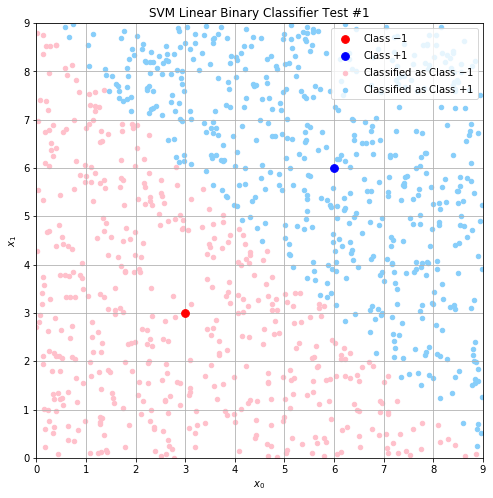

115
[0.12311629 0.11711603]
[[3. 3.]
 [6. 6.]]
[0.33334727 0.33334727]
-3.0001254473834473
2.121231642573227


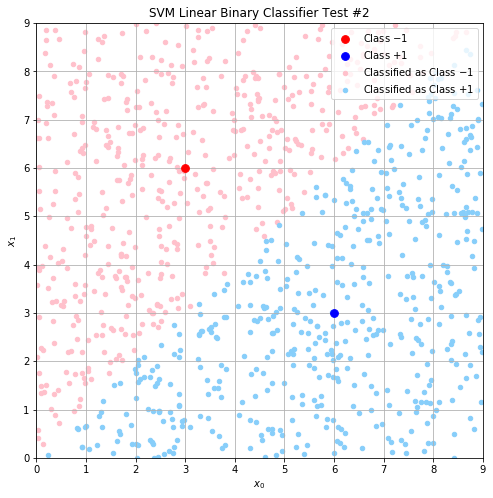

8
[0.11111112 0.11111112]
[[3. 6.]
 [6. 3.]]
[ 0.33333336 -0.33333336]
0.0
2.121320173854028


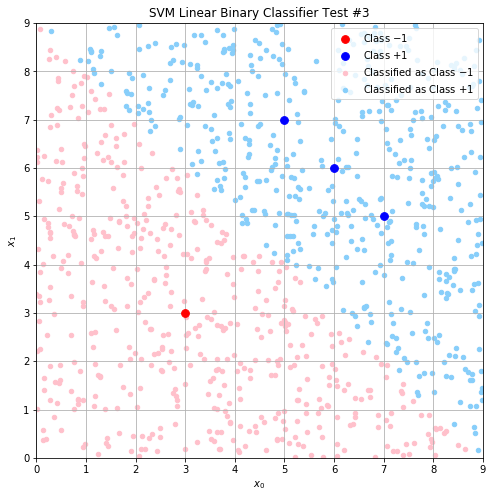

1507
[0.12314169 0.03904696 0.03904696 0.03904696]
[[3. 3.]
 [5. 7.]
 [7. 5.]
 [6. 6.]]
[0.33342013 0.33342013]
-3.000911377529935
2.1207681091593873


In [12]:
# Linear SVM Functionality Test #1.

linear_svm = LinearSVM()

X_train = np.array([[3.0, 3.0],
                    [6.0, 6.0]])

y_train = np.array([-1.0, +1.0])

linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

X_new = np.zeros((CLASS_N, 2))

for i in range(CLASS_N):
    X_new[i, 0] = np.random.uniform(0.0, 9.0)
    X_new[i, 1] = np.random.uniform(0.0, 9.0)

y_new = np.zeros(CLASS_N)

for i in range(CLASS_N):
    y_new[i] = linear_svm.predict(X_new[i])

plt.figure(figsize=(8, 8))
plt.xlim((0.0, 9.0))
plt.ylim((0.0, 9.0))
plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
plt.title("SVM Linear Binary Classifier Test #1")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
plt.grid(zorder=0)
plt.savefig("svm_test_1.pdf")
plt.show()

print(linear_svm.iters)
print(linear_svm.alphas)
print(linear_svm.sv)
print(linear_svm.w)
print(linear_svm.b)
print(linear_svm.margin)


# Linear SVM Functionality Test #2.

linear_svm = LinearSVM()

X_train = np.array([[3.0, 6.0],
                    [6.0, 3.0]])

y_train = np.array([-1.0, +1.0])

linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

X_new = np.zeros((CLASS_N, 2))

for i in range(CLASS_N):
    X_new[i, 0] = np.random.uniform(0.0, 9.0)
    X_new[i, 1] = np.random.uniform(0.0, 9.0)

y_new = np.zeros(CLASS_N)

for i in range(CLASS_N):
    y_new[i] = linear_svm.predict(X_new[i])

plt.figure(figsize=(8, 8))
plt.xlim((0.0, 9.0))
plt.ylim((0.0, 9.0))
plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
plt.title("SVM Linear Binary Classifier Test #2")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
plt.grid(zorder=0)
plt.savefig("svm_test_2.pdf")
plt.show()

print(linear_svm.iters)
print(linear_svm.alphas)
print(linear_svm.sv)
print(linear_svm.w)
print(linear_svm.b)
print(linear_svm.margin)


# SVM Functionality Test #3.

linear_svm = LinearSVM()

#X_train = np.array([[3.0, 3.0],
X_train = np.array([[3.0, 3.0],
                    #[3.0, 2.0],
                    #[2.0, 1.0],
                    [5.0, 7.0],
                    [7.0, 5.0],
                    [6.0, 6.0]])

y_train = np.array([-1.0, +1.0, +1.0, +1.0])

linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

X_new = np.zeros((CLASS_N, 2))

for i in range(CLASS_N):
    X_new[i, 0] = np.random.uniform(0.0, 9.0)
    X_new[i, 1] = np.random.uniform(0.0, 9.0)

y_new = np.zeros(CLASS_N)

for i in range(CLASS_N):
    y_new[i] = linear_svm.predict(X_new[i])

plt.figure(figsize=(8, 8))
plt.xlim((0.0, 9.0))
plt.ylim((0.0, 9.0))
plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
plt.title("SVM Linear Binary Classifier Test #3")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
plt.grid(zorder=0)
plt.savefig("svm_test_3.pdf")
plt.show()

print(linear_svm.iters)
print(linear_svm.alphas)
print(linear_svm.sv)
print(linear_svm.w)
print(linear_svm.b)
print(linear_svm.margin)


## SVM Functionality Test #2

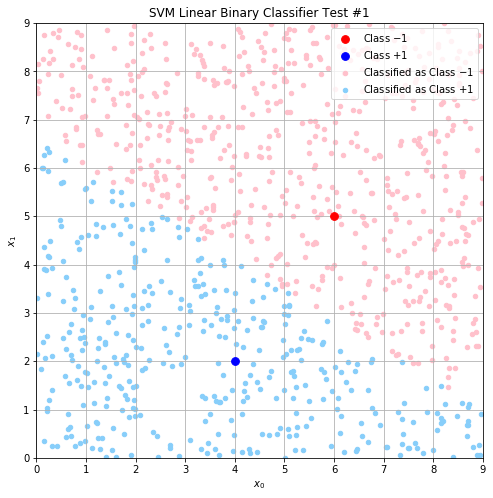

75
[0.16683212 0.16058542]
[[4. 2.]
 [6. 5.]]
[-0.29618403 -0.46926285]
3.1233401600882056
1.8020720859032666


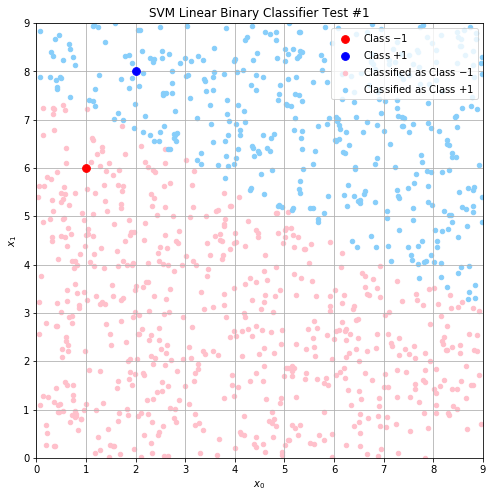

341
[0.43217392 0.44449906]
[[2. 8.]
 [1. 6.]]
[0.41984878 0.79039698]
-6.162551988956421
1.1173356120165452


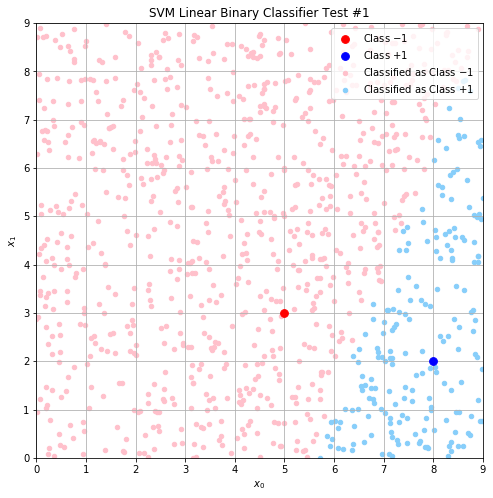

283
[0.21441117 0.2078672 ]
[[5. 3.]
 [8. 2.]]
[ 0.59088172 -0.22749913]
-3.2719833485408727
1.5793688443866218


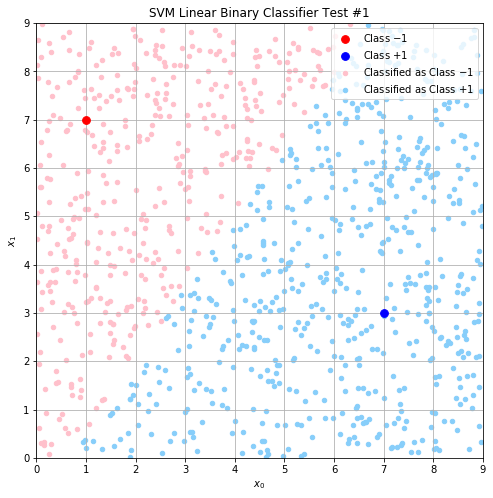

88
[0.0386264  0.03834186]
[[1. 7.]
 [7. 3.]]
[ 0.22976665 -0.15535921]
-0.1422705447103807
3.605407835090499


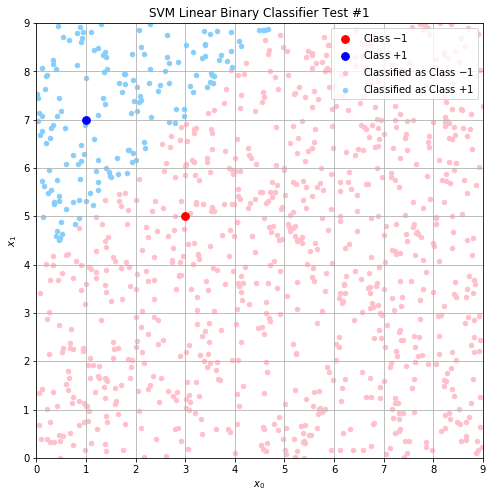

88
[0.25566351 0.25190378]
[[3. 5.]
 [1. 7.]]
[-0.51508676  0.48500888]
-1.879879756158826
1.41343923960193


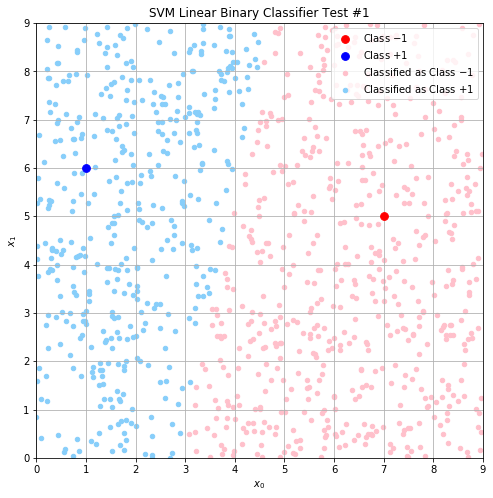

131
[0.05405492 0.05591714]
[[7. 5.]
 [1. 6.]]
[-0.32246726  0.06522829]
0.9311134635019349
3.039529601489167


In [13]:
linear_svm = LinearSVM()

for T in TRAIN_N:

    for plot in range(PLOTS):

        X_train = np.zeros((T, 2))
        y_train = np.zeros(T)

        X_train[:, 0] = np.random.choice(range(1, 9), size=(T), replace=False)
        X_train[:, 1] = np.random.choice(range(1, 9), size=(T), replace=False)

        y_train[:] = np.random.choice([-1.0, +1.0], size=(T))
        if len(y_train[y_train == -1.0]) == 0:
            y_train[np.random.randint(0, T)] = -1.0    
        if len(y_train[y_train == +1.0]) == 0:
            y_train[np.random.randint(0, T)] = +1.0    

        linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

        X_new = np.zeros((CLASS_N, 2))

        for i in range(CLASS_N):
            X_new[i, 0] = np.random.uniform(0.0, 9.0)
            X_new[i, 1] = np.random.uniform(0.0, 9.0)

        y_new = np.zeros(CLASS_N)

        for i in range(CLASS_N):
            y_new[i] = linear_svm.predict(X_new[i])

        plt.figure(figsize=(8, 8))
        plt.xlim((0.0, 9.0))
        plt.ylim((0.0, 9.0))
        plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
        plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
        plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
        plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
        #for sv in svm.sv:
        #    plt.scatter(sv[0], sv[1], s=300, facecolors='none', edgecolors='b')
        plt.title("SVM Linear Binary Classifier Test #1")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
        plt.grid(zorder=0)
        plt.savefig("svm_test_1.pdf")
        plt.show()

        print(linear_svm.iters)
        print(linear_svm.alphas)
        print(linear_svm.sv)
        print(linear_svm.w)
        print(linear_svm.b)
        print(linear_svm.margin)


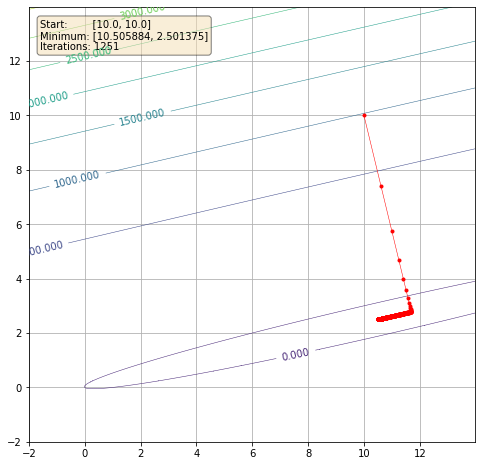

In [14]:
f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1]

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0,
                          34.0 * x[1] - 8.0 * x[0] - 1.0])

#f = lambda x: 0.5 * x @ H @ x - np.sum(x)
    
#df = lambda x: (np.transpose(H) + H) @ x - np.ones(len(x))



                     
x0 = np.array([10.0, 10.0], dtype=np.float64)

iters, xs = steepest_descent(f, df, None, x0)

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_0.pdf")
plt.show()

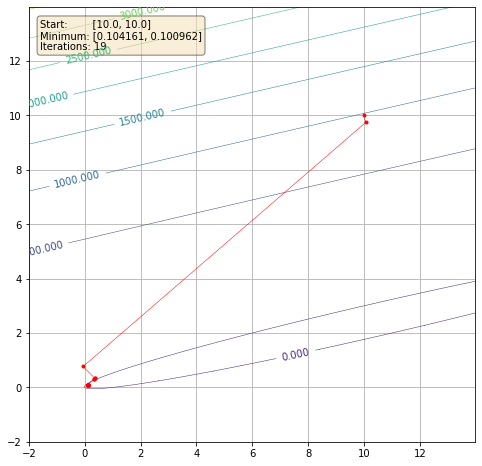

In [15]:
# Quadratic Penalty Method for solving the Dual Problem.

mu = 500

f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1] + mu / 2.0 * (-1.0 * x[0] + 1.0 *x[1])**2

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0 - mu * (-1.0 * x[0] + 1.0 * x[1]),
                          34.0 * x[1] - 8.0 * x[0] - 1.0 + mu * (-1.0 * x[0] + 1.0 * x[1])])



x0 = np.array([10.0, 10.0])

iters, xs = steepest_descent(f, df, None, x0)

alphas = xs[-1]

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_1.pdf")
plt.show()

# Non-Linear Binary SVM

## Implementation

In [16]:
# Kernel functions.

linear_kernel = lambda xi, xj: xi @ xj


In [17]:
# Non-Linear SVM implementation.

def quadratic_penalty_dual_solver(X, y, kernel, descent_function, mu=500):
    '''
    This function...
    '''
    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    iters, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (iters, xs)


import scipy

def scipy_cg_dual_solver(X, y, kernel, descent_function, mu=500):
    '''
    This function...
    '''
    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    result = scipy.optimize.minimize(f, np.full((len(X)), 1000000.0), method='CG')
    
    return (result.nit, np.array([result.x]))


def kkt_system_dual_solver(X, y, kernel, descent_function=None):
    '''
    This function...
    '''
    L = len(X)
    
    P = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            P[i, j] = y[i] * y[j] * kernel(X[i], X[j])
            
    q = np.full((L), -1.0)
    A = y
    KKT = np.zeros((L + 1, L + 1))
    KKT[0:L, 0:L] = P
    KKT[L, 0:L] = A
    KKT[0:L, L] = A
    RHS = np.zeros((L + 1))
    RHS[0:L] = -1.0 * q

    return (None, np.array([np.linalg.solve(KKT, RHS)[0:L]]))


def w_func(X, y, alphas):
    M, N = X.shape
    w = np.zeros((N))
    for i in range(M):
        w = w + alphas[i] * y[i] * X[i]
    return w


def b_func(X, y, alphas):
    b = 0.0
    S = np.argwhere(alphas > 0.0)
    for i in np.nditer(S):
        inner = 0.0
        for j in np.nditer(S):
            inner += alphas[j] * y[j] * np.dot(X[j], X[i])
        b += y[i] - inner
    return b / len(S)


def b_func_new(X_sv, y_sv, alphas_sv):
    b = 0.0
    for i in range(len(X_sv)):
        inner = 0.0
        for j in range(len(X_sv)):
            inner += alphas_sv[j] * y_sv[j] * np.dot(X_sv[j], X_sv[i])
        b += y[i] - inner
    return b / len(X_sv)


def margin_func(w):
    return 1.0 / np.linalg.norm(w)


class NonLinearSVM(object):
    
    def __init__(self):
        pass
    
    def train(self, X, y, kernel, dual_solver, descent_method):
        '''
        This method...
        '''
        assert len(X) == len(y), "X and y lengths mismatch"
        self.iters, self.xs = dual_solver(X, y, kernel, descent_method)
        self.alphas         = self.xs[-1]
        self.alphas_sv      = self.alphas[np.where(self.alphas > 0.0)]
        self.sv             = X[np.where(self.alphas > 0.0)]
        self.X_sv           = X[np.where(self.alphas > 0.0)]
        self.y_sv           = y[np.where(self.alphas > 0.0)]        
        #self.w              = w_func(self.X_sv, self.y_sv, self.alphas_sv)        
        #self.b              = b_func(self.X_sv, self.y_sv, self.alphas_sv)
        self.w              = w_func(X, y, self.alphas)        
        self.b              = b_func(X, y, self.alphas)

        self.margin         = 1.0 / np.linalg.norm(self.w)
        return
        
    def predict(self, x):
        '''
        This method...
        '''
        return np.sign(self.w @ x + self.b)



## Functionality Test